In [1]:
# coding:utf-8
import jieba
import numpy as np

def open_dict(Dict = 'hahah', path=r'data/Textming'):
    path = path + '%s.txt' % Dict
    dictionary = open(path, 'r', encoding='utf-8')
    dict = []
    for word in dictionary:
        word = word.strip('\n')
        dict.append(word)
    return dict
 
 
 
def judgeodd(num):
    if (num % 2) == 0:
        return 'even'
    else:
        return 'odd'
 
 
#注意，这里你要修改path路径。
deny_word = open_dict(Dict = 'deny', path= r'D:/MSBA/NLP/ChineseNLP_Sentiment/')
posdict = open_dict(Dict = 'positive', path= r'D:/MSBA/NLP/ChineseNLP_Sentiment/')
negdict = open_dict(Dict = 'negative', path= r'D:/MSBA/NLP/ChineseNLP_Sentiment/')
degree_word = open_dict(Dict = 'level', path= r'D:/MSBA/NLP/ChineseNLP_Sentiment/')
mostdict = degree_word[degree_word.index('extreme')+1 : degree_word.index('very')]#权重4，即在情感词前乘以4
verydict = degree_word[degree_word.index('very')+1 : degree_word.index('more')]#权重3
moredict = degree_word[degree_word.index('more')+1 : degree_word.index('ish')]#权重2
ishdict = degree_word[degree_word.index('ish')+1 : degree_word.index('last')]#权重0.5
 
 
 
def sentiment_score_list(dataset):
    seg_sentence = dataset.split('。')
 
    count1 = []
    count2 = []
    for sen in seg_sentence: #循环遍历每一个评论
        segtmp = jieba.lcut(sen, cut_all=False)  #把句子进行分词，以列表的形式返回
        i = 0 #记录扫描到的词的位置
        a = 0 #记录情感词的位置
        poscount = 0 #积极词的第一次分值
        poscount2 = 0 #积极词反转后的分值
        poscount3 = 0 #积极词的最后分值（包括叹号的分值）
        negcount = 0
        negcount2 = 0
        negcount3 = 0
        for word in segtmp:
            if word in posdict:  # 判断词语是否是情感词
                poscount += 1
                c = 0
                for w in segtmp[a:i]:  # 扫描情感词前的程度词
                    if w in mostdict:
                        poscount *= 4.0
                    elif w in verydict:
                        poscount *= 3.0
                    elif w in moredict:
                        poscount *= 2.0
                    elif w in ishdict:
                        poscount *= 0.5
                    elif w in deny_word:
                        c += 1
                if judgeodd(c) == 'odd':  # 扫描情感词前的否定词数
                    poscount *= -1.0
                    poscount2 += poscount
                    poscount = 0
                    poscount3 = poscount + poscount2 + poscount3
                    poscount2 = 0
                else:
                    poscount3 = poscount + poscount2 + poscount3
                    poscount = 0
                a = i + 1  # 情感词的位置变化
 
            elif word in negdict:  # 消极情感的分析，与上面一致
                negcount += 1
                d = 0
                for w in segtmp[a:i]:
                    if w in mostdict:
                        negcount *= 4.0
                    elif w in verydict:
                        negcount *= 3.0
                    elif w in moredict:
                        negcount *= 2.0
                    elif w in ishdict:
                        negcount *= 0.5
                    elif w in degree_word:
                        d += 1
                if judgeodd(d) == 'odd':
                    negcount *= -1.0
                    negcount2 += negcount
                    negcount = 0
                    negcount3 = negcount + negcount2 + negcount3
                    negcount2 = 0
                else:
                    negcount3 = negcount + negcount2 + negcount3
                    negcount = 0
                a = i + 1
            elif word == '！' or word == '!':  ##判断句子是否有感叹号
                for w2 in segtmp[::-1]:  # 扫描感叹号前的情感词，发现后权值+2，然后退出循环
                    if w2 in posdict or negdict:
                        poscount3 += 2
                        negcount3 += 2
                        break
            i += 1 # 扫描词位置前移
 
 
            # 以下是防止出现负数的情况
            pos_count = 0
            neg_count = 0
            if poscount3 < 0 and negcount3 > 0:
                neg_count += negcount3 - poscount3
                pos_count = 0
            elif negcount3 < 0 and poscount3 > 0:
                pos_count = poscount3 - negcount3
                neg_count = 0
            elif poscount3 < 0 and negcount3 < 0:
                neg_count = -poscount3
                pos_count = -negcount3
            else:
                pos_count = poscount3
                neg_count = negcount3
 
            count1.append([pos_count, neg_count])
        count2.append(count1)
        count1 = []
 
    return count2
 
def sentiment_score(senti_score_list):
    score = []
    for review in senti_score_list:
        score_array = np.array(review)
        Pos = np.sum(score_array[:, 0])
        Neg = np.sum(score_array[:, 1])
        AvgPos = np.mean(score_array[:, 0])
        AvgPos = float('%.1f'%AvgPos)
        AvgNeg = np.mean(score_array[:, 1])
        AvgNeg = float('%.1f'%AvgNeg)
        StdPos = np.std(score_array[:, 0])
        StdPos = float('%.1f'%StdPos)
        StdNeg = np.std(score_array[:, 1])
        StdNeg = float('%.1f'%StdNeg)
        score.append([Pos, Neg, AvgPos, AvgNeg, StdPos, StdNeg]) #积极、消极情感值总和(最重要)，积极、消极情感均值，积极、消极情感方差。
    return score
 
def EmotionByScore(data):
    result_list=sentiment_score(sentiment_score_list(data))
    return result_list[0][0],result_list[0][1]
    
 
 
def JudgingEmotionByScore(Pos, Neg):
    if Pos > Neg:
        str='1'
    elif Pos < Neg:
        str='-1'
    elif Pos == Neg:
        str='0'
    return str

In [1]:
import re
from snownlp import sentiment
import numpy as np
import pandas as pd
import seaborn as sns
import pymysql
from snownlp import SnowNLP
from snownlp import sentiment
from snownlp.sentiment import Sentiment
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')
import jieba
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('df_final.csv',encoding='utf-8')
df = df[(df.content != '转发微博')&(df.content != 'repost')&(df.content != '')]
df = df.dropna()
df = df.reset_index(drop=True)

In [3]:
df['sentiment'] = ''

In [6]:
%%time
for i in range(df.shape[0]):
    comm = df.content[i]
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)','',comm)
    text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', ',',text)
    r='[’！？：；【】，、。《》!"#$%&\'()（）“”…*+,-./:;<=>?@[\\]^_`{|}~]+'
    text = re.sub(r, '', text)
    if text:
        a,b=EmotionByScore(text)
        emotion=JudgingEmotionByScore(a,b)
        df['sentiment'][i] = emotion
    else:
        df['sentiment'][i] = 0.5

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Wall time: 43min 28s


In [13]:
df.sentiment.value_counts()

1      20224
-1     12024
0       4032
0.5      375
Name: sentiment, dtype: int64

In [39]:
df.to_csv('jieba_sentiment_data.csv')

In [14]:
data_copy = df.copy()
data_copy['created_at'] =  pd.to_datetime(data_copy['created_at'], format='%Y%m%d %H:%M')
data_copy['sentiment'] = data_copy['sentiment'].astype('float')
data_groupby = data_copy.groupby([data_copy['created_at'].dt.date])['sentiment'].mean()

D:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


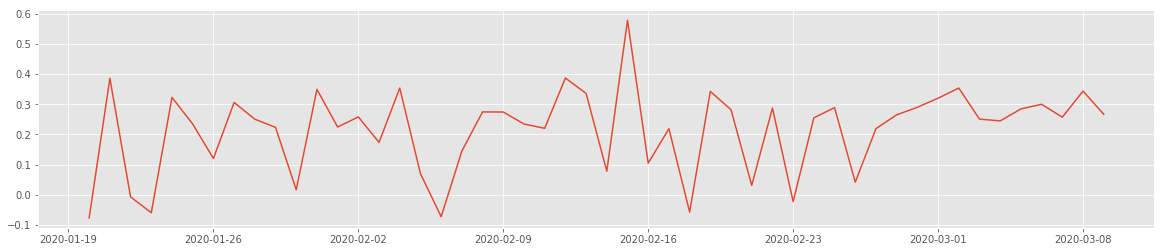

In [15]:
plt.figure(figsize=(20,4))
plt.plot(data_groupby)